In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.utils import resample
import math

### Read in Dataset and Preprocess

In [2]:
students_df = pd.read_csv("train.csv")

In [3]:
df = students_df.copy()
df.head()

,ID,Salary,DOJ,DOL,Original Designation,Designation,Domain,JobCity,Gender,DOB,10percentage,10board,12graduation,12percentage,12board,CollegeID,CollegeTier,Degree,Specialization,collegeGPA,CollegeCityID,CollegeCityTier,CollegeState,GraduationYear,English,Logical,Quant,DomainScore,ComputerProgramming,ElectronicsAndSemicon,ComputerScience,MechanicalEngg,ElectricalEngg,TelecomEngg,CivilEngg,conscientiousness,agreeableness,extraversion,nueroticism,openess_to_experience
0,42418,435000.0,5/1/10 0:00,6/1/14 0:00,electrical engineer,electrical engineer,Engineering,Bhopal,f,10/23/87 0:00,65.0,cbse,2005,54.0,cbse,402,1,B.Tech/B.E.,biomedical engineering,65.90,402,0,Madhya Pradesh,2010,405,425,405,0.0,0,0,0,0,0,0,0,0.9737,-0.2793,-1.2148,-0.8778,0.5024
1,214964,315000.0,8/1/11 0:00,7/1/12 0:00,senior software engineer,senior software engineer,Engineering,Mumbai,f,12/25/88 0:00,88.4,cbse,2006,79.2,cbse,332,1,B.Tech/B.E.,biomedical engineering,69.54,332,0,Punjab,2011,525,705,524,0.0,0,0,0,0,0,0,0,0.9737,-0.1232,-1.0697,1.5899,0.9763
2,900218,420000.0,7/1/10 0:00,8/1/11 0:00,management trainee,trainee manager,Management,NCR,m,1/11/88 0:00,82.0,cbse,2005,75.8,cbse,443,1,M.Tech./M.E.,other,82.50,443,0,Uttar Pradesh,2014,625,520,705,0.0,0,0,0,0,0,0,0,-1.8825,0.5454,-0.9122,-0.1076,-1.4356
3,220655,400000.0,6/1/11 0:00,3/1/13 0:00,team leader,technical lead,Management,Chandigarh,m,11/16/89 0:00,88.2,cbse,2007,77.8,cbse,285,1,B.Tech/B.E.,chemical engineering,62.40,285,0,Punjab,2011,595,695,575,0.0,0,0,0,0,0,0,0,-1.0355,0.9688,-0.6343,-0.4078,0.0284
4,962376,700000.0,7/1/14 0:00,NaN,product manager,product manager,Management,Jaipur,m,1/3/92 0:00,87.4,cbse,2009,74.0,state board,436,1,M.Tech./M.E.,other,72.79,436,0,Uttarakhand,2014,625,450,655,0.0,0,0,0,0,0,0,0,-0.3027,-0.4536,-0.6048,-0.8682,0.0973


In [4]:
from datetime import datetime
# Drop irrelevant columns
df = df.drop('ID',1)
df = df.drop('DOJ',1)
df = df.drop('DOL',1)
df = df.drop('Original Designation',1)
df = df.drop('Designation',1)

# Trim all string inputs
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Encoding Gender as Binary (0 = Male, 1 = Female)
df['IsMale'] = df['Gender'].apply(lambda x: 1 if x.lower() == 'm' else 0)
df = df.drop('Gender',1)

today = datetime.now()

# Covering DOB to Age
df['Age'] = df['DOB'].apply(lambda x: np.round((today - datetime.strptime(x, '%m/%d/%y %H:%M')).days / 365),0)
df = df.drop('DOB',1)

df.head()

,Salary,Domain,JobCity,10percentage,10board,12graduation,12percentage,12board,CollegeID,CollegeTier,Degree,Specialization,collegeGPA,CollegeCityID,CollegeCityTier,CollegeState,GraduationYear,English,Logical,Quant,DomainScore,ComputerProgramming,ElectronicsAndSemicon,ComputerScience,MechanicalEngg,ElectricalEngg,TelecomEngg,CivilEngg,conscientiousness,agreeableness,extraversion,nueroticism,openess_to_experience,IsMale,Age
0,435000.0,Engineering,Bhopal,65.0,cbse,2005,54.0,cbse,402,1,B.Tech/B.E.,biomedical engineering,65.90,402,0,Madhya Pradesh,2010,405,425,405,0.0,0,0,0,0,0,0,0,0.9737,-0.2793,-1.2148,-0.8778,0.5024,0,30
1,315000.0,Engineering,Mumbai,88.4,cbse,2006,79.2,cbse,332,1,B.Tech/B.E.,biomedical engineering,69.54,332,0,Punjab,2011,525,705,524,0.0,0,0,0,0,0,0,0,0.9737,-0.1232,-1.0697,1.5899,0.9763,0,29
2,420000.0,Management,NCR,82.0,cbse,2005,75.8,cbse,443,1,M.Tech./M.E.,other,82.50,443,0,Uttar Pradesh,2014,625,520,705,0.0,0,0,0,0,0,0,0,-1.8825,0.5454,-0.9122,-0.1076,-1.4356,1,30
3,400000.0,Management,Chandigarh,88.2,cbse,2007,77.8,cbse,285,1,B.Tech/B.E.,chemical engineering,62.40,285,0,Punjab,2011,595,695,575,0.0,0,0,0,0,0,0,0,-1.0355,0.9688,-0.6343,-0.4078,0.0284,1,28
4,700000.0,Management,Jaipur,87.4,cbse,2009,74.0,state board,436,1,M.Tech./M.E.,other,72.79,436,0,Uttarakhand,2014,625,450,655,0.0,0,0,0,0,0,0,0,-0.3027,-0.4536,-0.6048,-0.8682,0.0973,1,26


In [5]:
df.groupby ('CollegeID').size().nlargest(20)

CollegeID
272      94
64       38
44       35
11759    35
47       33
350      31
55       29
6874     28
3076     24
429      22
51       19
184      19
285      19
8195     19
10932    19
75       18
347      18
1622     18
4948     18
7376     18
dtype: int64

In [6]:
cols = ['ComputerProgramming', 'ElectronicsAndSemicon', 'ComputerScience', 'MechanicalEngg', 'ElectricalEngg', 'TelecomEngg', 'CivilEngg']
for col in cols:
    df[col] = df[col].apply(lambda x: np.nan if x == 0 else x/900)

df['SecScore'] = df[cols].mean(axis=1)
df['SecScore'] = df['SecScore'].apply(lambda x: -1 if math.isnan(x) else x)

for col in cols:
    df[col] = df[col].apply(lambda x: 0 if math.isnan(x) else 1)

In [7]:
df = df.rename(columns={'conscientiousness': 'Conscientiousness',
                        'agreeableness': 'Agreeableness',
                        'extraversion': 'Extraversion',
                        'nueroticism': 'Nueroticism',
                        'openess_to_experience': 'OTE'})

#df = pd.concat([df, pd.get_dummies(df['CollegeState'])], axis=1)
df = pd.concat([df, pd.get_dummies(df["Specialization"])], axis=1)
df = pd.concat([df, pd.get_dummies(df["Degree"])], axis=1)
df = pd.concat([df, pd.get_dummies(df["12board"])], axis=1)
df = pd.concat([df, pd.get_dummies(df["10board"])], axis=1)

#df = df[df.JobCity.isin(list(df.groupby(['JobCity']).size().nlargest(20).reset_index(drop=False)['JobCity']))]
#df = pd.concat([df, pd.get_dummies(df['JobCity'])], axis=1)

df['Domain'] = df.Domain.astype('category')
df = df.drop("Salary",1)
df = df.drop("JobCity",1)
df = df.drop("10board",1)
df = df.drop("12board",1)
df = df.drop("Degree",1)
df = df.drop("Specialization",1)

df.head()

,Domain,10percentage,12graduation,12percentage,CollegeID,CollegeTier,collegeGPA,CollegeCityID,CollegeCityTier,CollegeState,GraduationYear,English,Logical,Quant,DomainScore,ComputerProgramming,ElectronicsAndSemicon,ComputerScience,MechanicalEngg,ElectricalEngg,TelecomEngg,CivilEngg,Conscientiousness,Agreeableness,Extraversion,Nueroticism,OTE,IsMale,Age,SecScore,biomedical engineering,chemical engineering,civil engineering,computer application,computer science,electrical engineering,electronics engineering,information technology,mechanical engineering,other,B.Tech/B.E.,M.Sc. (Tech.),M.Tech./M.E.,MCA,cbse,icse,state board,cbse,icse,state board
0,Engineering,65.0,2005,54.0,402,1,65.90,402,0,Madhya Pradesh,2010,405,425,405,0.0,0,0,0,0,0,0,0,0.9737,-0.2793,-1.2148,-0.8778,0.5024,0,30,-1.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
1,Engineering,88.4,2006,79.2,332,1,69.54,332,0,Punjab,2011,525,705,524,0.0,0,0,0,0,0,0,0,0.9737,-0.1232,-1.0697,1.5899,0.9763,0,29,-1.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
2,Management,82.0,2005,75.8,443,1,82.50,443,0,Uttar Pradesh,2014,625,520,705,0.0,0,0,0,0,0,0,0,-1.8825,0.5454,-0.9122,-0.1076,-1.4356,1,30,-1.0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0
3,Management,88.2,2007,77.8,285,1,62.40,285,0,Punjab,2011,595,695,575,0.0,0,0,0,0,0,0,0,-1.0355,0.9688,-0.6343,-0.4078,0.0284,1,28,-1.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
4,Management,87.4,2009,74.0,436,1,72.79,436,0,Uttarakhand,2014,625,450,655,0.0,0,0,0,0,0,0,0,-0.3027,-0.4536,-0.6048,-0.8682,0.0973,1,26,-1.0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0


In [8]:
df.isnull().sum(axis = 0)

Domain                     0
10percentage               0
12graduation               0
12percentage               0
CollegeID                  0
CollegeTier                0
collegeGPA                 0
CollegeCityID              0
CollegeCityTier            0
CollegeState               0
GraduationYear             0
English                    0
Logical                    0
Quant                      0
DomainScore                0
ComputerProgramming        0
ElectronicsAndSemicon      0
ComputerScience            0
MechanicalEngg             0
ElectricalEngg             0
TelecomEngg                0
CivilEngg                  0
Conscientiousness          0
Agreeableness              0
Extraversion               0
Nueroticism                0
OTE                        0
IsMale                     0
Age                        0
SecScore                   0
biomedical engineering     0
chemical engineering       0
civil engineering          0
computer application       0
computer scien

In [9]:
#df['Salary'] = (df['Salary'] - np.mean(df['Salary']))/np.std(df['Salary'])
df['10percentage'] = (df['10percentage'] - np.mean(df['10percentage']))/np.std(df['10percentage'])
df['12percentage'] = (df['12percentage'] - np.mean(df['12percentage']))/np.std(df['12percentage'])
df['collegeGPA'] = (df['collegeGPA'] - np.mean(df['collegeGPA']))/np.std(df['collegeGPA'])
df['English'] = (df['English'] - np.mean(df['English']))/np.std(df['English'])
df['Logical'] = (df['Logical'] - np.mean(df['Logical']))/np.std(df['Logical'])
df['Quant'] = (df['Quant'] - np.mean(df['Quant']))/np.std(df['Quant'])
df['DomainScore'] = (df['DomainScore'] - np.mean(df['DomainScore']))/np.std(df['DomainScore'])
df['ComputerProgramming'] = (df['ComputerProgramming'] - np.mean(df['ComputerProgramming']))/np.std(df['ComputerProgramming'])
df['ElectronicsAndSemicon'] = (df['ElectronicsAndSemicon'] - np.mean(df['ElectronicsAndSemicon']))/np.std(df['ElectronicsAndSemicon'])
df['ComputerScience'] = (df['ComputerScience'] - np.mean(df['ComputerScience']))/np.std(df['ComputerScience'])
df['MechanicalEngg'] = (df['MechanicalEngg'] - np.mean(df['MechanicalEngg']))/np.std(df['MechanicalEngg'])
df['ElectricalEngg'] = (df['ElectricalEngg'] - np.mean(df['ElectricalEngg']))/np.std(df['ElectricalEngg'])
df['TelecomEngg'] = (df['TelecomEngg'] - np.mean(df['TelecomEngg']))/np.std(df['TelecomEngg'])
df['CivilEngg'] = (df['CivilEngg'] - np.mean(df['CivilEngg']))/np.std(df['CivilEngg'])
df['Conscientiousness'] = (df['Conscientiousness'] - np.mean(df['Conscientiousness']))/np.std(df['Conscientiousness'])
df['Agreeableness'] = (df['Agreeableness'] - np.mean(df['Agreeableness']))/np.std(df['Agreeableness'])
df['Extraversion'] = (df['Extraversion'] - np.mean(df['Extraversion']))/np.std(df['Extraversion'])
df['Nueroticism'] = (df['Nueroticism'] - np.mean(df['Nueroticism']))/np.std(df['Nueroticism'])
df['OTE'] = (df['OTE'] - np.mean(df['OTE']))/np.std(df['OTE'])
df['SecScore'] = (df['SecScore'] - np.mean(df['SecScore']))/np.std(df['SecScore'])

df.head()

,Domain,10percentage,12graduation,12percentage,CollegeID,CollegeTier,collegeGPA,CollegeCityID,CollegeCityTier,CollegeState,GraduationYear,English,Logical,Quant,DomainScore,ComputerProgramming,ElectronicsAndSemicon,ComputerScience,MechanicalEngg,ElectricalEngg,TelecomEngg,CivilEngg,Conscientiousness,Agreeableness,Extraversion,Nueroticism,OTE,IsMale,Age,SecScore,biomedical engineering,chemical engineering,civil engineering,computer application,computer science,electrical engineering,electronics engineering,information technology,mechanical engineering,other,B.Tech/B.E.,M.Sc. (Tech.),M.Tech./M.E.,MCA,cbse,icse,state board,cbse,icse,state board
0,Engineering,-1.310888,2005,-1.858964,402,1,-0.781777,402,0,Madhya Pradesh,2010,-0.920235,-0.883880,-0.885405,-1.890883,-1.897306,-0.631901,-0.539474,-0.249667,-0.205109,-0.320743,-0.103168,0.983823,-0.452957,-1.278601,-0.704111,0.635243,0,30,-5.063834,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
1,Engineering,1.063951,2006,0.430880,332,1,-0.290194,332,0,Punjab,2011,0.223457,2.345520,0.087848,-1.890883,-1.897306,-0.631901,-0.539474,-0.249667,-0.205109,-0.320743,-0.103168,0.983823,-0.286945,-1.126122,1.745115,1.105209,0,29,-5.063834,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
2,Management,0.414423,2005,0.121933,443,1,1.460059,443,0,Uttar Pradesh,2014,1.176533,0.211809,1.568174,-1.890883,-1.897306,-0.631901,-0.539474,-0.249667,-0.205109,-0.320743,-0.103168,-1.794998,0.424111,-0.960613,0.060323,-1.286670,1,30,-5.063834,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0
3,Management,1.043653,2007,0.303667,285,1,-1.254454,285,0,Punjab,2011,0.890610,2.230184,0.504957,-1.890883,-1.897306,-0.631901,-0.539474,-0.249667,-0.205109,-0.320743,-0.103168,-0.970945,0.874396,-0.668581,-0.237630,0.165177,1,28,-5.063834,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
4,Management,0.962462,2009,-0.041627,436,1,0.148720,436,0,Uttarakhand,2014,1.176533,-0.595541,1.159245,-1.890883,-1.897306,-0.631901,-0.539474,-0.249667,-0.205109,-0.320743,-0.103168,-0.257997,-0.638325,-0.637581,-0.694583,0.233506,1,26,-5.063834,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0


In [10]:
df_new = df._get_numeric_data()
df_new = df_new.drop('id', 1)
df_new = df_new.drop('12graduation', 1)
df_new = df_new.drop('CollegeID', 1)
df_new = df_new.drop('CollegeTier', 1)
df_new = df_new.drop('CollegeCityID', 1)
df_new = df_new.drop('CollegeCityTier', 1)
#df_new = df_new.drop('GraduationYear', 1)
#X = df_new.drop('Domain',1)
df_new['Domain'] = df['Domain']
df_new.head()

,10percentage,12percentage,collegeGPA,GraduationYear,English,Logical,Quant,DomainScore,ComputerProgramming,ElectronicsAndSemicon,ComputerScience,MechanicalEngg,ElectricalEngg,TelecomEngg,CivilEngg,Conscientiousness,Agreeableness,Extraversion,Nueroticism,OTE,IsMale,SecScore,biomedical engineering,chemical engineering,civil engineering,computer application,computer science,electrical engineering,electronics engineering,information technology,mechanical engineering,other,B.Tech/B.E.,M.Sc. (Tech.),M.Tech./M.E.,MCA,cbse,icse,state board,cbse,icse,state board,Domain
0,-1.310888,-1.858964,-0.781777,2010,-0.920235,-0.883880,-0.885405,-1.890883,-1.897306,-0.631901,-0.539474,-0.249667,-0.205109,-0.320743,-0.103168,0.983823,-0.452957,-1.278601,-0.704111,0.635243,0,-5.063834,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,Engineering
1,1.063951,0.430880,-0.290194,2011,0.223457,2.345520,0.087848,-1.890883,-1.897306,-0.631901,-0.539474,-0.249667,-0.205109,-0.320743,-0.103168,0.983823,-0.286945,-1.126122,1.745115,1.105209,0,-5.063834,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,Engineering
2,0.414423,0.121933,1.460059,2014,1.176533,0.211809,1.568174,-1.890883,-1.897306,-0.631901,-0.539474,-0.249667,-0.205109,-0.320743,-0.103168,-1.794998,0.424111,-0.960613,0.060323,-1.286670,1,-5.063834,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,Management
3,1.043653,0.303667,-1.254454,2011,0.890610,2.230184,0.504957,-1.890883,-1.897306,-0.631901,-0.539474,-0.249667,-0.205109,-0.320743,-0.103168,-0.970945,0.874396,-0.668581,-0.237630,0.165177,1,-5.063834,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,Management
4,0.962462,-0.041627,0.148720,2014,1.176533,-0.595541,1.159245,-1.890883,-1.897306,-0.631901,-0.539474,-0.249667,-0.205109,-0.320743,-0.103168,-0.257997,-0.638325,-0.637581,-0.694583,0.233506,1,-5.063834,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,Management


In [11]:
from sklearn.model_selection import train_test_split
X = df_new.drop('Domain',1)
X_train, X_test, y_train, y_test = train_test_split(X, df_new['Domain'], test_size=0.20, random_state=42)

In [12]:
X_train['Domain'] = y_train
X_train.head()

C:\ProgramData\Anaconda3\envs\python1\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,10percentage,12percentage,collegeGPA,GraduationYear,English,Logical,Quant,DomainScore,ComputerProgramming,ElectronicsAndSemicon,ComputerScience,MechanicalEngg,ElectricalEngg,TelecomEngg,CivilEngg,Conscientiousness,Agreeableness,Extraversion,Nueroticism,OTE,IsMale,SecScore,biomedical engineering,chemical engineering,civil engineering,computer application,computer science,electrical engineering,electronics engineering,information technology,mechanical engineering,other,B.Tech/B.E.,M.Sc. (Tech.),M.Tech./M.E.,MCA,cbse,icse,state board,cbse,icse,state board,Domain
1068,-1.194175,-1.858964,-0.768272,2013,-1.349119,-0.076530,-1.907730,0.732646,0.527063,-0.631901,-0.539474,-0.249667,-0.205109,-0.320743,-0.103168,-0.143972,-0.286945,-0.515998,-1.053973,-1.244821,1,0.452962,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,Engineering
549,0.921867,1.466762,-0.357719,2010,-1.682696,0.384813,-0.067545,-0.152215,0.527063,-0.631901,-0.539474,-0.249667,-0.205109,-0.320743,-0.103168,0.683097,0.044867,0.246605,0.228951,0.321866,1,0.136587,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,Engineering
557,-0.458381,0.449054,-0.194308,2012,0.699995,0.730820,1.077459,-0.152215,0.527063,-0.631901,-0.539474,-0.249667,-0.205109,-0.320743,-0.103168,0.532685,1.620973,0.627854,-0.120910,0.321866,1,0.136587,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,Engineering
3712,1.632289,1.048775,1.392534,2014,1.081225,-0.076530,-0.108438,0.086997,0.527063,-0.631901,-0.539474,4.005338,-0.205109,-0.320743,-0.103168,0.999681,-0.107107,-0.637581,-0.820434,-0.146514,1,0.021900,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,Engineering
602,0.921867,0.776174,0.285121,2012,-0.729620,-0.422537,0.913887,-0.028754,0.527063,-0.631901,-0.539474,-0.249667,-0.205109,-0.320743,-0.103168,-1.572494,-0.369898,0.055981,1.861765,0.008588,1,0.176133,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,Tech


In [13]:
X_train.groupby('Domain').size().nlargest(20)

Domain
Engineering     2145
Tech             299
QA               187
UX/UI Design     111
Management       110
Business          85
Support           66
HR                42
Research          36
Operations        33
Education         32
Sales             29
Marketing         12
Finance            3
dtype: int64

In [14]:
from sklearn.utils import resample
x_df = X_train
df_majority = x_df[x_df.Domain=='Engineering']
df_minority1 = x_df[x_df.Domain=='Tech']
df_minority_upsampled = resample(df_minority1, 
                                 replace=True, 
                                 n_samples=2145,
                                 random_state=123)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])


df_minority2 = x_df[x_df.Domain=='QA']
df_minority_upsampled = resample(df_minority2, 
                                 replace=True, 
                                 n_samples=2145,
                                 random_state=123)
df_upsampled = pd.concat([df_upsampled, df_minority_upsampled])

df_minority3 = x_df[x_df.Domain=='UX/UI Design']
df_minority_upsampled = resample(df_minority3, 
                                 replace=True, 
                                 n_samples=2145,
                                 random_state=123)
df_upsampled = pd.concat([df_upsampled, df_minority_upsampled])

df_minority4 = x_df[x_df.Domain=='Management']
df_minority_upsampled = resample(df_minority4, 
                                 replace=True, 
                                 n_samples=2145,
                                 random_state=123)
df_upsampled = pd.concat([df_upsampled, df_minority_upsampled])

df_minority5 = x_df[x_df.Domain=='Business']
df_minority_upsampled = resample(df_minority5, 
                                 replace=True, 
                                 n_samples=2145,
                                 random_state=123)
df_upsampled = pd.concat([df_upsampled, df_minority_upsampled])

df_minority6 = x_df[x_df.Domain=='Support']
df_minority_upsampled = resample(df_minority6, 
                                 replace=True, 
                                 n_samples=2145,
                                 random_state=123)
df_upsampled = pd.concat([df_upsampled, df_minority_upsampled])

df_minority7 = x_df[x_df.Domain=='HR']
df_minority_upsampled = resample(df_minority7, 
                                 replace=True, 
                                 n_samples=2145,
                                 random_state=123)
df_upsampled = pd.concat([df_upsampled, df_minority_upsampled])

df_minority8 = x_df[x_df.Domain=='Research']
df_minority_upsampled = resample(df_minority8, 
                                 replace=True, 
                                 n_samples=2145,
                                 random_state=123)
df_upsampled = pd.concat([df_upsampled, df_minority_upsampled])

df_minority9 = x_df[x_df.Domain=='Education']
df_minority_upsampled = resample(df_minority9, 
                                 replace=True, 
                                 n_samples=2145,
                                 random_state=123)
df_upsampled = pd.concat([df_upsampled, df_minority_upsampled])

df_minority10 = x_df[x_df.Domain=='Operations']
df_minority_upsampled = resample(df_minority10, 
                                 replace=True, 
                                 n_samples=2145,
                                 random_state=123)
df_upsampled = pd.concat([df_upsampled, df_minority_upsampled])

df_minority11 = x_df[x_df.Domain=='Sales']
df_minority_upsampled = resample(df_minority11, 
                                 replace=True, 
                                 n_samples=2145,
                                 random_state=123)
df_upsampled = pd.concat([df_upsampled, df_minority_upsampled])

df_minority12 = x_df[x_df.Domain=='Marketing']
df_minority_upsampled = resample(df_minority12, 
                                 replace=True, 
                                 n_samples=2145,
                                 random_state=123)
df_upsampled = pd.concat([df_upsampled, df_minority_upsampled])

df_minority13 = x_df[x_df.Domain=='Finance']
df_minority_upsampled = resample(df_minority13, 
                                 replace=True, 
                                 n_samples=2145,
                                 random_state=123)
df_upsampled = pd.concat([df_upsampled, df_minority_upsampled])

In [15]:
df_upsampled.Domain.value_counts()

UX/UI Design    2145
Tech            2145
Support         2145
Sales           2145
Research        2145
QA              2145
Operations      2145
Marketing       2145
Management      2145
HR              2145
Finance         2145
Engineering     2145
Education       2145
Business        2145
Name: Domain, dtype: int64

In [16]:
for val in df_upsampled.columns:
    print(val)

10percentage
12percentage
collegeGPA
GraduationYear
English
Logical
Quant
DomainScore
ComputerProgramming
ElectronicsAndSemicon
ComputerScience
MechanicalEngg
ElectricalEngg
TelecomEngg
CivilEngg
Conscientiousness
Agreeableness
Extraversion
Nueroticism
OTE
IsMale
SecScore
biomedical engineering
chemical engineering
civil engineering
computer application
computer science
electrical engineering
electronics engineering
information technology
mechanical engineering
other
B.Tech/B.E.
M.Sc. (Tech.)
M.Tech./M.E.
MCA
cbse
icse
state board
cbse
icse
state board
Domain


In [23]:
df_upsampled.GraduationYear = 2017 - df.GraduationYear
new_df = df_upsampled.iloc[:,-14:]
new_df_1 = df_upsampled[["Conscientiousness","Agreeableness","Extraversion","Nueroticism","GraduationYear","English","Logical","Quant","SecScore","Domain"]]
new_df_test = X_test[["Conscientiousness","Agreeableness","Extraversion","Nueroticism","GraduationYear","English","Logical","Quant","SecScore"]]
new_df_2 = pd.concat([new_df,new_df_1],axis=1)

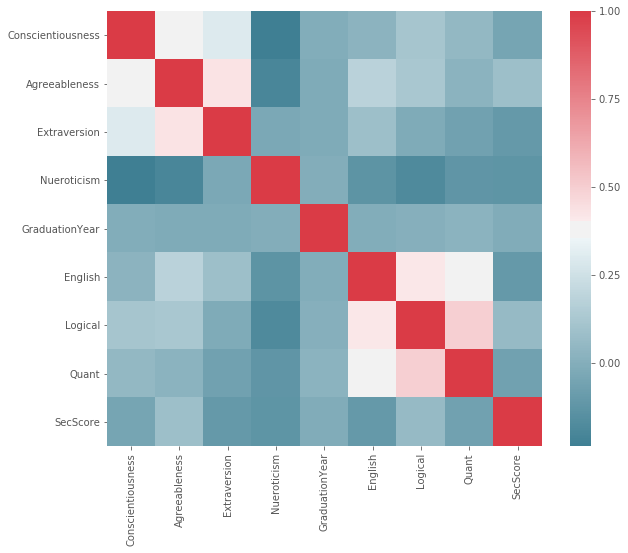

In [18]:
f, ax = plt.subplots(figsize=(10, 8))

corr = new_df_1.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

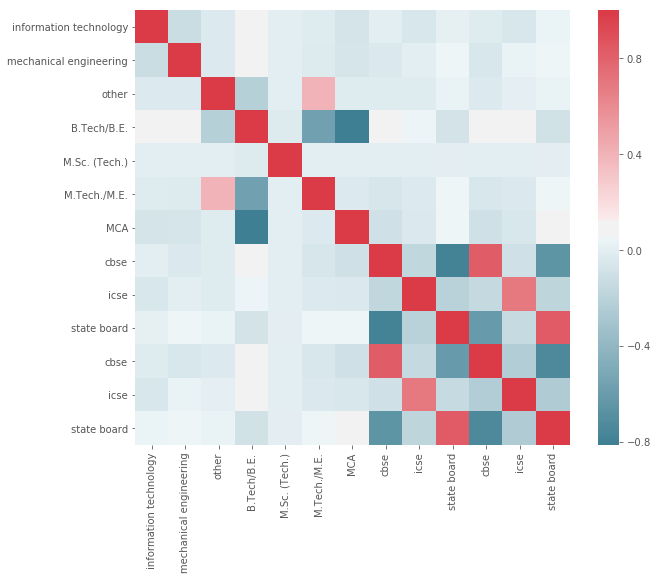

In [49]:
f, ax = plt.subplots(figsize=(10, 8))

corr = new_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

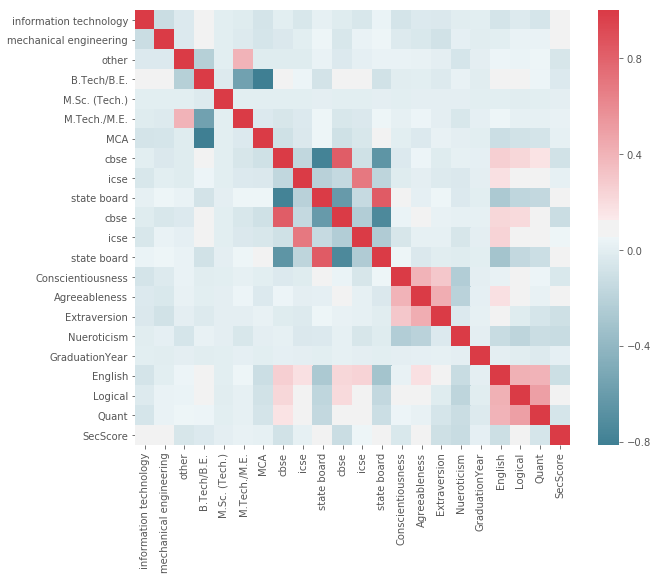

In [50]:
f, ax = plt.subplots(figsize=(10, 8))

corr = new_df_2.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [54]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'min_samples_split':range(2,10,1)}

dtree = DecisionTreeClassifier()
clf = GridSearchCV(dtree, parameters, cv=10, verbose=10)

X = new_df_1.drop('Domain',1)
Y = new_df_1['Domain']
clf.fit(X,Y)
results = clf.cv_results_
#accuracy = cross_validate(clf, X, Y,cv=10, return_train_score=True)

#train_accuracy = np.mean(accuracy['train_score'])
#test_accuracy = np.mean(accuracy['test_score'])

#print("Training accuracy across 10 folds = {0:.2f}%".format(100*train_accuracy.mean()))
#print("Testing accuracy across 10 folds {0:.2f}%".format(100*test_accuracy.mean()))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] min_samples_split=2 .............................................
[CV] .... min_samples_split=2, score=0.9717607973421927, total=   0.0s
[CV] min_samples_split=2 .............................................
[CV] .... min_samples_split=2, score=0.9677740863787375, total=   0.0s
[CV] min_samples_split=2 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] .... min_samples_split=2, score=0.9704318936877077, total=   0.0s
[CV] min_samples_split=2 .............................................
[CV] .... min_samples_split=2, score=0.9727574750830564, total=   0.0s
[CV] min_samples_split=2 .............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


[CV] .... min_samples_split=2, score=0.9720930232558139, total=   0.0s
[CV] min_samples_split=2 .............................................
[CV] .... min_samples_split=2, score=0.9712950600801068, total=   0.0s
[CV] min_samples_split=2 .............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.7s remaining:    0.0s


[CV] .... min_samples_split=2, score=0.9706275033377837, total=   0.0s
[CV] min_samples_split=2 .............................................
[CV] .... min_samples_split=2, score=0.9699599465954606, total=   0.0s
[CV] min_samples_split=2 .............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.0s remaining:    0.0s


[CV] .... min_samples_split=2, score=0.9689586114819759, total=   0.0s
[CV] min_samples_split=2 .............................................
[CV] ..... min_samples_split=2, score=0.972630173564753, total=   0.0s
[CV] min_samples_split=3 .............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.1s remaining:    0.0s


[CV] .... min_samples_split=3, score=0.9724252491694352, total=   0.0s
[CV] min_samples_split=3 .............................................
[CV] ...... min_samples_split=3, score=0.96843853820598, total=   0.0s
[CV] min_samples_split=3 .............................................
[CV] .... min_samples_split=3, score=0.9720930232558139, total=   0.0s
[CV] min_samples_split=3 .............................................
[CV] ..... min_samples_split=3, score=0.973421926910299, total=   0.0s
[CV] min_samples_split=3 .............................................
[CV] .... min_samples_split=3, score=0.9747508305647841, total=   0.0s
[CV] min_samples_split=3 .............................................
[CV] .... min_samples_split=3, score=0.9702937249666221, total=   0.0s
[CV] min_samples_split=3 .............................................
[CV] .... min_samples_split=3, score=0.9709612817089452, total=   0.0s
[CV] min_samples_split=3 .............................................
[CV] .

[CV] .... min_samples_split=8, score=0.9676234979973297, total=   0.0s
[CV] min_samples_split=8 .............................................
[CV] .... min_samples_split=8, score=0.9706275033377837, total=   0.0s
[CV] min_samples_split=9 .............................................
[CV] .... min_samples_split=9, score=0.9674418604651163, total=   0.0s
[CV] min_samples_split=9 .............................................
[CV] .... min_samples_split=9, score=0.9664451827242525, total=   0.0s
[CV] min_samples_split=9 .............................................
[CV] .... min_samples_split=9, score=0.9654485049833887, total=   0.0s
[CV] min_samples_split=9 .............................................
[CV] ...... min_samples_split=9, score=0.96843853820598, total=   0.0s
[CV] min_samples_split=9 .............................................
[CV] .... min_samples_split=9, score=0.9724252491694352, total=   0.0s
[CV] min_samples_split=9 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   10.8s finished


In [55]:
print(results['mean_test_score'])

[ 0.97082917  0.97122877  0.97026307  0.97112887  0.97026307  0.96913087
  0.96946387  0.96769897]


In [56]:
print(clf.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


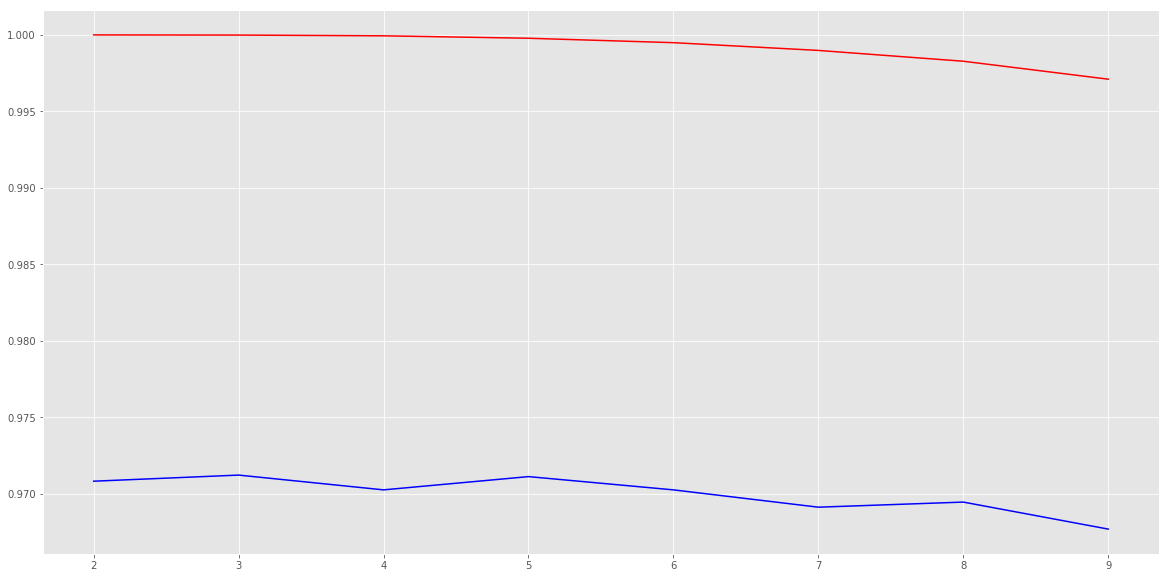

In [63]:

fig,ax= plt.subplots(figsize=(20, 10))
#plt.xticks(np.arange(1,21,1))
ax.set_xticklabels(range(1,10,1))
ax.locator_params(tight=True, nbins=8)
ax.plot(results['mean_test_score'],color='blue')
ax.plot(results['mean_train_score'],color='red')
plt.show()

In [66]:
from sklearn.ensemble import RandomForestClassifier

parameters = {'min_samples_split':range(2,15,1)}

dtree = RandomForestClassifier()
clf = GridSearchCV(dtree, parameters, cv=10, verbose=10)

X = new_df_1.drop('Domain',1)
Y = new_df_1['Domain']
clf.fit(X,Y)
results = clf.cv_results_
#accuracy = cross_validate(clf, X, Y,cv=10, return_train_score=True)
print(results['mean_test_score'])

Fitting 10 folds for each of 13 candidates, totalling 130 fits
[CV] min_samples_split=2 .............................................
[CV] .... min_samples_split=2, score=0.9930232558139535, total=   0.2s
[CV] min_samples_split=2 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .... min_samples_split=2, score=0.9903654485049834, total=   0.2s
[CV] min_samples_split=2 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] .... min_samples_split=2, score=0.9943521594684386, total=   0.2s
[CV] min_samples_split=2 .............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s


[CV] .... min_samples_split=2, score=0.9933554817275747, total=   0.2s
[CV] min_samples_split=2 .............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s


[CV] .... min_samples_split=2, score=0.9943521594684386, total=   0.2s
[CV] min_samples_split=2 .............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s remaining:    0.0s


[CV] .... min_samples_split=2, score=0.9899866488651535, total=   0.2s
[CV] min_samples_split=2 .............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.1s remaining:    0.0s


[CV] .... min_samples_split=2, score=0.9933244325767691, total=   0.2s
[CV] min_samples_split=2 .............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.4s remaining:    0.0s


[CV] .... min_samples_split=2, score=0.9936582109479306, total=   0.2s
[CV] min_samples_split=2 .............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.8s remaining:    0.0s


[CV] .... min_samples_split=2, score=0.9956608811748998, total=   0.2s
[CV] min_samples_split=2 .............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.1s remaining:    0.0s


[CV] .... min_samples_split=2, score=0.9939919893190922, total=   0.2s
[CV] min_samples_split=3 .............................................
[CV] .... min_samples_split=3, score=0.9920265780730897, total=   0.2s
[CV] min_samples_split=3 .............................................
[CV] .... min_samples_split=3, score=0.9913621262458472, total=   0.2s
[CV] min_samples_split=3 .............................................
[CV] .... min_samples_split=3, score=0.9906976744186047, total=   0.2s
[CV] min_samples_split=3 .............................................
[CV] .... min_samples_split=3, score=0.9940199335548173, total=   0.2s
[CV] min_samples_split=3 .............................................
[CV] .... min_samples_split=3, score=0.9926910299003322, total=   0.2s
[CV] min_samples_split=3 .............................................
[CV] .... min_samples_split=3, score=0.9949933244325768, total=   0.2s
[CV] min_samples_split=3 .............................................
[CV] .

[CV] .... min_samples_split=8, score=0.9909879839786382, total=   0.2s
[CV] min_samples_split=8 .............................................
[CV] .... min_samples_split=8, score=0.9929906542056075, total=   0.2s
[CV] min_samples_split=8 .............................................
[CV] .... min_samples_split=8, score=0.9909879839786382, total=   0.2s
[CV] min_samples_split=9 .............................................
[CV] .... min_samples_split=9, score=0.9880398671096345, total=   0.2s
[CV] min_samples_split=9 .............................................
[CV] .... min_samples_split=9, score=0.9883720930232558, total=   0.2s
[CV] min_samples_split=9 .............................................
[CV] ..... min_samples_split=9, score=0.988704318936877, total=   0.2s
[CV] min_samples_split=9 .............................................
[CV] .... min_samples_split=9, score=0.9903654485049834, total=   0.2s
[CV] min_samples_split=9 .............................................
[CV] .

[CV] ... min_samples_split=14, score=0.9839786381842457, total=   0.2s
[CV] min_samples_split=14 ............................................
[CV] ... min_samples_split=14, score=0.9839786381842457, total=   0.2s
[CV] min_samples_split=14 ............................................
[CV] ... min_samples_split=14, score=0.9833110814419226, total=   0.2s
[CV] min_samples_split=14 ............................................
[CV] .... min_samples_split=14, score=0.985981308411215, total=   0.2s
[CV] min_samples_split=14 ............................................
[CV] .... min_samples_split=14, score=0.985981308411215, total=   0.2s


[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:   46.1s finished


[ 0.99320679  0.99330669  0.99254079  0.99287379  0.99247419  0.99124209
  0.99000999  0.98914419  0.98734599  0.98684649  0.98598069  0.98464868
  0.98401598]


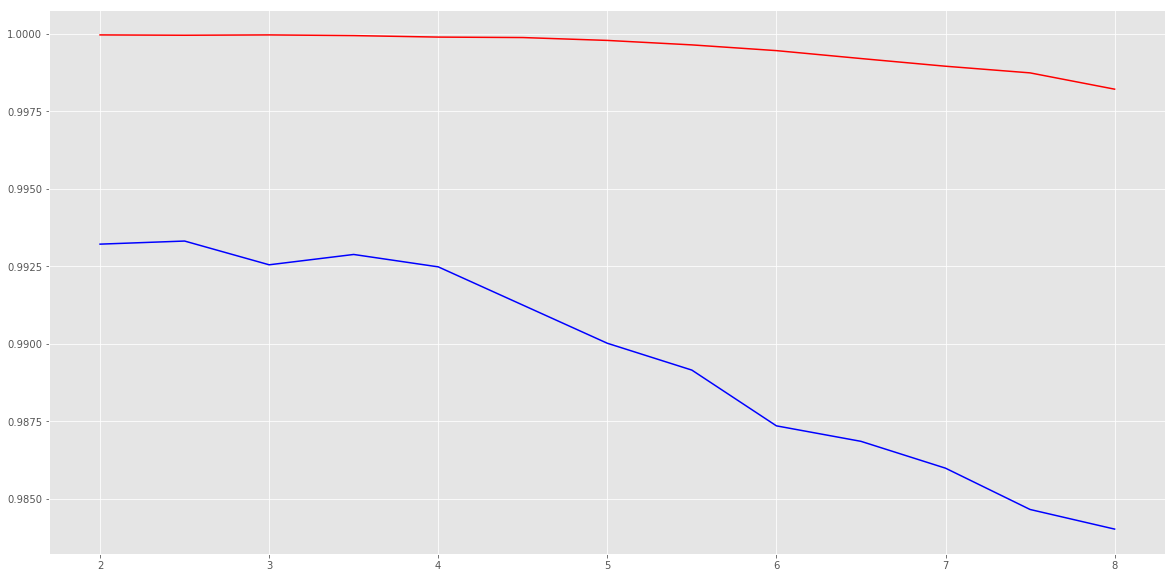

In [67]:
fig,ax= plt.subplots(figsize=(20, 10))
#plt.xticks(np.arange(1,21,1))
ax.set_xticklabels(range(1,10,1))
ax.locator_params(tight=True, nbins=8)
ax.plot(results['mean_test_score'],color='blue')
ax.plot(results['mean_train_score'],color='red')
plt.show()

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=700,max_features='sqrt',min_samples_leaf=4, max_depth=5)

Y_pred = rf.fit(X,Y).predict(new_df_test)

In [39]:
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_recall_fscore_support, fbeta_score
precision_recall_fscore_support(y_test, Y_pred, average='macro')

C:\ProgramData\Anaconda3\envs\python1\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0.07644086043346672, 0.078199485322738252, 0.022415729725709897, None)

In [40]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=700,max_features='sqrt',min_samples_leaf=4, max_depth=5)
rf.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
rf_pred = pd.DataFrame(rf.predict_proba(new_df_test))
rf_pred['Prediction'] = rf.predict(new_df_test)
rf_pred.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,Prediction
0,0.069379,0.129593,0.097760,0.000000,0.077929,0.066238,0.071709,0.053927,0.089741,0.079154,0.032376,0.067411,0.096240,0.068543,Education
1,0.105367,0.068436,0.083357,0.062281,0.044833,0.056500,0.040700,0.065166,0.061919,0.075179,0.062451,0.133714,0.075310,0.064789,Support
2,0.075630,0.186305,0.074967,0.000000,0.044288,0.087241,0.032629,0.070670,0.069888,0.076837,0.073536,0.073361,0.083077,0.051571,Education
3,0.047072,0.187196,0.090948,0.000000,0.082039,0.067627,0.078253,0.035706,0.085037,0.082515,0.031596,0.056225,0.080654,0.075132,Education
4,0.064673,0.124864,0.068913,0.010534,0.076122,0.072721,0.042869,0.080441,0.082068,0.074010,0.057168,0.097042,0.070468,0.078107,Education


In [43]:
rf_pred.Prediction.value_counts()

Education       527
Engineering      49
Research         48
Marketing        39
Business         32
Management       31
HR               25
Tech             14
Sales            12
Operations       10
Support           4
QA                3
Finance           2
UX/UI Design      2
Name: Prediction, dtype: int64

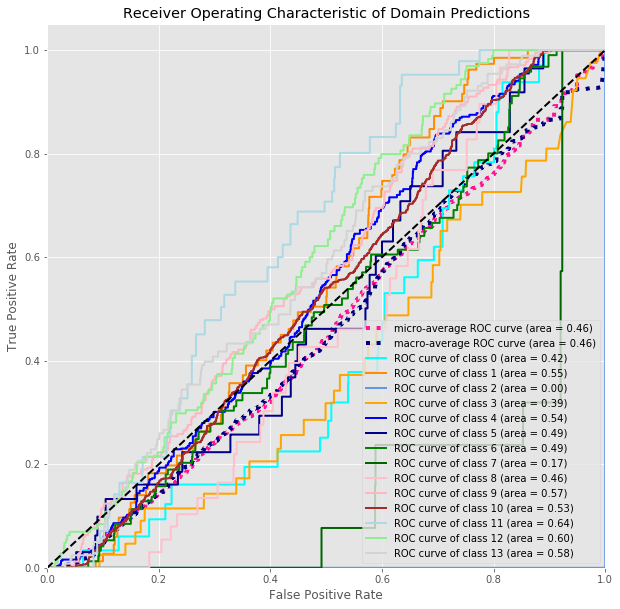

In [35]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
X = df_upsampled.drop('Domain',1)
y = df_upsampled['Domain']
# Compute ROC curve and ROC area for each class
Y_test1 = label_binarize(y, classes=list(set(y)))
Y_pred1 = rf.predict_proba(X)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(0, 14):
    fpr[i], tpr[i], _ = roc_curve(Y_test1[:, i], Y_pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test1.ravel(), Y_pred1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(14)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(14):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 14

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'orange', 'blue', 'darkblue', 'green', 'darkgreen', 'pink', 'lightpink', 'brown', 'lightblue', 'lightgreen', 'lightgrey'])
for i, color in zip(range(14), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Domain Predictions')
plt.legend(loc="lower right")
plt.show()

In [26]:
accuracy_score(Y_pred, y_test)

0.45238095238095238

Convert categorical data into codes for ML input

In [24]:
#ovrc = OneVsRestClassifier(LinearSVC(random_state=0, class_weight='balanced'))
X = df_upsampled.drop('Domain',1)
y = df_upsampled['Domain']
ovrc = OneVsRestClassifier(RandomForestClassifier())
Y_pred = ovrc.fit(X, y).predict(X_test)

In [25]:
accuracy_score(Y_pred, y_test)

0.64661654135338342

In [26]:
pd.DataFrame(confusion_matrix(Y_pred, y_test))

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,22,9,511,6,24,3,6,36,7,5,22,71,28
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,5,1,1,0,0,0,0,0,1,2,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,1,0,0,0,0,0,0,0,0,0,0
7,2,0,0,0,1,0,0,1,0,0,1,2,1
8,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
dict( enumerate(df['Domain'].cat.categories) )

{0: 'Business',
 1: 'Education',
 2: 'Engineering',
 3: 'Finance',
 4: 'HR',
 5: 'Management',
 6: 'Marketing',
 7: 'Operations',
 8: 'QA',
 9: 'Research',
 10: 'Sales',
 11: 'Support',
 12: 'Tech',
 13: 'UX/UI Design'}

In [27]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

X = df_upsampled.drop('Domain',1)
y = df_upsampled['Domain']

forest = RandomForestClassifier(n_estimators=250,random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 17 (0.067985)
2. feature 0 (0.067901)
3. feature 5 (0.067406)
4. feature 2 (0.064194)
5. feature 3 (0.063560)
6. feature 1 (0.063529)
7. feature 16 (0.063367)
8. feature 4 (0.062999)
9. feature 20 (0.062567)
10. feature 14 (0.060612)
11. feature 15 (0.059141)
12. feature 18 (0.058910)
13. feature 6 (0.055539)
14. feature 7 (0.015270)
15. feature 38 (0.013569)
16. feature 19 (0.013017)
17. feature 8 (0.011228)
18. feature 27 (0.011087)
19. feature 40 (0.010296)
20. feature 37 (0.009975)
21. feature 9 (0.009584)
22. feature 25 (0.009040)
23. feature 35 (0.008679)
24. feature 22 (0.007510)
25. feature 28 (0.007460)
26. feature 12 (0.006803)
27. feature 10 (0.006168)
28. feature 29 (0.005854)
29. feature 11 (0.005650)
30. feature 39 (0.005276)
31. feature 26 (0.003825)
32. feature 31 (0.003688)
33. feature 33 (0.003436)
34. feature 36 (0.003407)
35. feature 21 (0.002850)
36. feature 34 (0.002531)
37. feature 24 (0.002314)
38. feature 23 (0.001513)
39. feature 13

In [27]:
X = df_upsampled.drop('Domain', 1)
imp_ftr = list(X.columns.values)
print(imp_ftr[2], imp_ftr[5],imp_ftr[0], imp_ftr[17], 
      imp_ftr[1], imp_ftr[3], imp_ftr[20], imp_ftr[16])

collegeGPA Quant 10percentage Nueroticism 12percentage English SecScore Extraversion
